In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/0566.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/0115.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/0050.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/0501.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/1231.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/0263.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/0133.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/1017.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/0563.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/0693.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/1522.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/0857.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/0006.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/1088.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/0516.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/1746.png
/kaggle/input/cybersquad/Blur2Sharp/sharp_Image/1479.png
/kaggle/input/cybersquad/Blur2S

In [14]:
import os

sharp_path = "/kaggle/input/cybersquad/Blur2Sharp/sharp_Image"
blur_path  = "/kaggle/input/cybersquad/Blur2Sharp/blur_Image"

print("sharp images:", len(os.listdir(sharp_path)))
print("blur images :", len(os.listdir(blur_path)))


sharp images: 1800
blur images : 1800


In [15]:
# delete the previous Restormer folder
!rm -rf /kaggle/working/Restormer

# freshly clone the repo again
!git clone https://github.com/swz30/Restormer.git


Cloning into 'Restormer'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 309 (delta 67), reused 56 (delta 56), pack-reused 202 (from 1)
Receiving objects: 100% (309/309), 1.56 MiB | 25.34 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [16]:
!pip install basicsr facexlib


In [17]:
!pip install gfpgan
!pip install realesrgan


In [19]:
!ls -R /kaggle/working/Restormer


/kaggle/working/Restormer:
basicsr		    demo.py    INSTALL.md	  README.md  train.sh
Defocus_Deblurring  Denoising  LICENSE.md	  setup.cfg  VERSION
demo		    Deraining  Motion_Deblurring  setup.py

/kaggle/working/Restormer/basicsr:
data  metrics  models  test.py	train.py  utils  version.py

/kaggle/working/Restormer/basicsr/data:
data_sampler.py  meta_info		  single_image_dataset.py
data_util.py	 paired_image_dataset.py  transforms.py
ffhq_dataset.py  prefetch_dataloader.py   video_test_dataset.py
__init__.py	 reds_dataset.py	  vimeo90k_dataset.py

/kaggle/working/Restormer/basicsr/data/meta_info:
meta_info_DIV2K800sub_GT.txt		meta_info_Vimeo90K_test_fast_GT.txt
meta_info_REDS4_test_GT.txt		meta_info_Vimeo90K_test_GT.txt
meta_info_REDS_GT.txt			meta_info_Vimeo90K_test_medium_GT.txt
meta_info_REDSofficial4_test_GT.txt	meta_info_Vimeo90K_test_slow_GT.txt
meta_info_REDSval_official_test_GT.txt	meta_info_Vimeo90K_train_GT.txt

/kaggle/working/Restormer/basicsr/metrics:
fid.py	     metric_u

In [35]:
!ls /kaggle/working


Restormer


In [4]:
# Step 1: Monkey patch torchvision for grayscale
import torchvision.transforms.functional as F
import types
import torchvision

torchvision.transforms.functional_tensor = types.SimpleNamespace()
torchvision.transforms.functional_tensor.rgb_to_grayscale = F.rgb_to_grayscale

# Step 2: Import Restormer from your actual local file directly
import importlib.util
import sys
import torch
import os

# 📍 Path to restormer_arch.py inside your Restormer repo
restormer_file = '/kaggle/working/Restormer/basicsr/models/archs/restormer_arch.py'

spec = importlib.util.spec_from_file_location("restormer_arch", restormer_file)
restormer_module = importlib.util.module_from_spec(spec)
sys.modules["restormer_arch"] = restormer_module
spec.loader.exec_module(restormer_module)

# Now you can import Restormer from the manually loaded module
Restormer = restormer_module.Restormer

# Step 3: Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Restormer()

checkpoint = torch.load('/kaggle/input/restormer-weights/motion_deblurring.pth', map_location=device)
model.load_state_dict(checkpoint['params'])
model.to(device)
model.eval()

print("✅ Restormer teacher loaded successfully from local!")


✅ Restormer teacher loaded successfully from local!


Available images in blur_Image folder: ['0566.png', '0115.png', '0050.png', '0501.png', '1231.png']
Testing on file: /kaggle/input/cybersquad/Blur2Sharp/blur_Image/0566.png


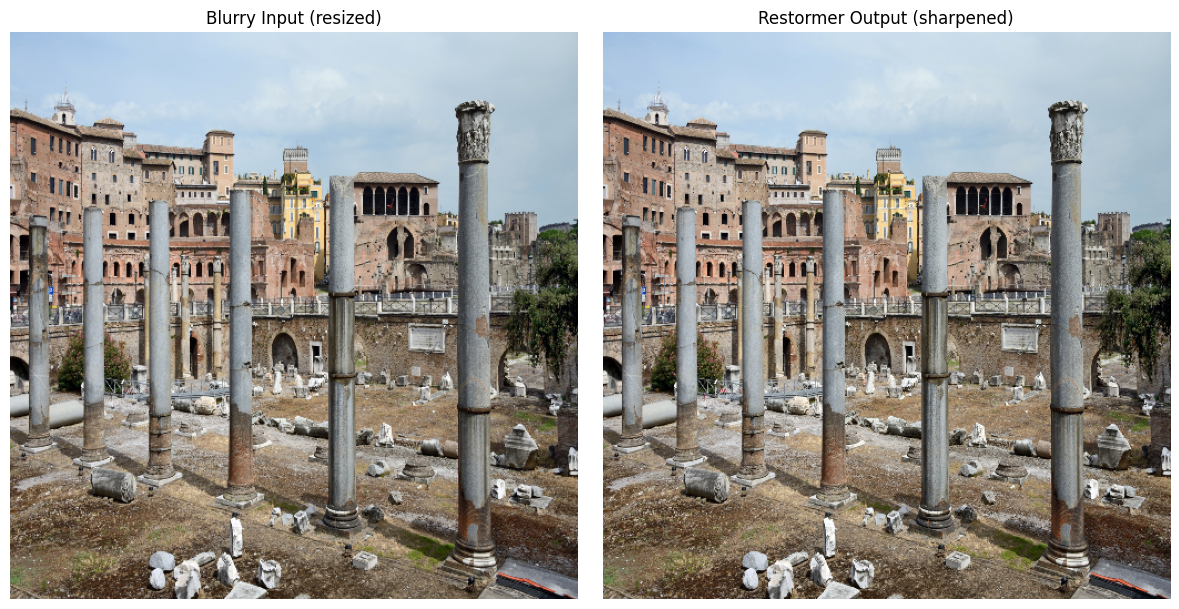

In [5]:
# ✅ Imports
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Define blur image directory
blur_dir = "/kaggle/input/cybersquad/Blur2Sharp/blur_Image"

# ✅ List and choose a file
all_files = os.listdir(blur_dir)
print("Available images in blur_Image folder:", all_files[:5])

if len(all_files) == 0:
    raise ValueError("No images found in the blur_Image folder!")
else:
    test_img = os.path.join(blur_dir, all_files[0])  # pick first image

print("Testing on file:", test_img)

# ✅ Read and resize image
img = cv2.imread(test_img)
if img is None:
    raise ValueError(f"Could not read image at {test_img}")
img = cv2.resize(img, (512, 512))  # prevent OOM

# ✅ Convert BGR to RGB and normalize
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0

# ✅ Convert to torch tensor
img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().to(device)

# ✅ Run through Restormer (teacher)
with torch.no_grad():
    output = model(img_tensor)

# ✅ Convert output tensor to image
output_img = output.squeeze(0).permute(1, 2, 0).cpu().numpy()
output_img = np.clip(output_img * 255, 0, 255).astype(np.uint8)

# ✅ Show input and output side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow((img * 255).astype(np.uint8))
plt.title("Blurry Input (resized)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_img)
plt.title("Restormer Output (sharpened)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    """
    A simple residual block:
    conv → ReLU → conv → add input
    """
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return out + identity


In [7]:
class ResidualUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super(ResidualUNet, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, 3, padding=1),
            nn.ReLU(inplace=True),
            ResidualBlock(features)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(features, features*2, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            ResidualBlock(features*2)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*2, features*4, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            ResidualBlock(features*4)
        )
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(features*4, features*2, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.ReLU(inplace=True),
            ResidualBlock(features*2)
        )
        
        self.up2 = nn.ConvTranspose2d(features*2, features, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.ReLU(inplace=True),
            ResidualBlock(features)
        )
        
        # Final
        self.final = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        # encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        
        # bottleneck
        b  = self.bottleneck(e2)
        
        # decoder
        d1 = self.up1(b)
        d1 = d1 + e2  # skip connection
        d1 = self.dec1(d1)
        
        d2 = self.up2(d1)
        d2 = d2 + e1  # skip connection
        d2 = self.dec2(d2)
        
        return self.final(d2)


In [8]:
student = ResidualUNet().to(device)
print(student)


ResidualUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
 

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import cv2

# ----------------------------------------------------------
# Student Residual UNet with residual blocks
# ----------------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return out + identity

class ResidualUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super(ResidualUNet, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, features, 3, padding=1),
            nn.ReLU(inplace=True),
            ResidualBlock(features)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(features, features*2, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            ResidualBlock(features*2)
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*2, features*4, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            ResidualBlock(features*4)
        )
        self.up1 = nn.ConvTranspose2d(features*4, features*2, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.ReLU(inplace=True),
            ResidualBlock(features*2)
        )
        self.up2 = nn.ConvTranspose2d(features*2, features, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.ReLU(inplace=True),
            ResidualBlock(features)
        )
        self.final = nn.Conv2d(features, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        b  = self.bottleneck(e2)
        d1 = self.up1(b) + e2
        d1 = self.dec1(d1)
        d2 = self.up2(d1) + e1
        d2 = self.dec2(d2)
        return self.final(d2)

# ----------------------------------------------------------
# Dataset
# ----------------------------------------------------------
class BlurSharpDataset(Dataset):
    def __init__(self, blur_dir, sharp_dir):
        self.blur_dir = blur_dir
        self.sharp_dir = sharp_dir
        self.image_names = os.listdir(blur_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        blur_path  = os.path.join(self.blur_dir, self.image_names[idx])
        sharp_path = os.path.join(self.sharp_dir, self.image_names[idx])

        blur  = cv2.imread(blur_path)
        sharp = cv2.imread(sharp_path)
        blur  = cv2.cvtColor(blur, cv2.COLOR_BGR2RGB)
        sharp = cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB)
        blur  = cv2.resize(blur, (256,256)) / 255.0
        sharp = cv2.resize(sharp, (256,256)) / 255.0

        blur  = torch.from_numpy(blur).permute(2,0,1).float()
        sharp = torch.from_numpy(sharp).permute(2,0,1).float()
        return blur, sharp

# ----------------------------------------------------------
# Set up data
# ----------------------------------------------------------
train_dataset = BlurSharpDataset(
    blur_dir="/kaggle/input/cybersquad/Blur2Sharp/blur_Image",
    sharp_dir="/kaggle/input/cybersquad/Blur2Sharp/sharp_Image"
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# ----------------------------------------------------------
# Initialize student
# ----------------------------------------------------------
student = ResidualUNet().to(device)
optimizer = optim.Adam(student.parameters(), lr=1e-4)
loss_fn = nn.L1Loss()

# teacher is already loaded as `model` in your previous cell
# ----------------------------------------------------------
# Training loop
# ----------------------------------------------------------
alpha = 0.8  # weight for ground-truth loss
beta  = 0.2  # weight for distillation loss
num_epochs = 5

for epoch in range(num_epochs):
    student.train()
    running_loss = 0
    for blur_batch, sharp_batch in train_loader:
        blur_batch  = blur_batch.to(device)
        sharp_batch = sharp_batch.to(device)

        # teacher predictions
        with torch.no_grad():
            teacher_preds = model(blur_batch)

        # student predictions
        student_preds = student(blur_batch)

        # L1 to ground truth
        loss_gt = loss_fn(student_preds, sharp_batch)

        # distillation loss to teacher output
        loss_teacher = loss_fn(student_preds, teacher_preds)

        # combined loss
        total_loss = alpha * loss_gt + beta * loss_teacher

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Avg Loss: {avg_loss:.4f}")

print("✅ Student training completed.")


Epoch 1/5 | Avg Loss: 0.0371
Epoch 2/5 | Avg Loss: 0.0144
Epoch 3/5 | Avg Loss: 0.0124
Epoch 4/5 | Avg Loss: 0.0112
Epoch 5/5 | Avg Loss: 0.0104
✅ Student training completed.


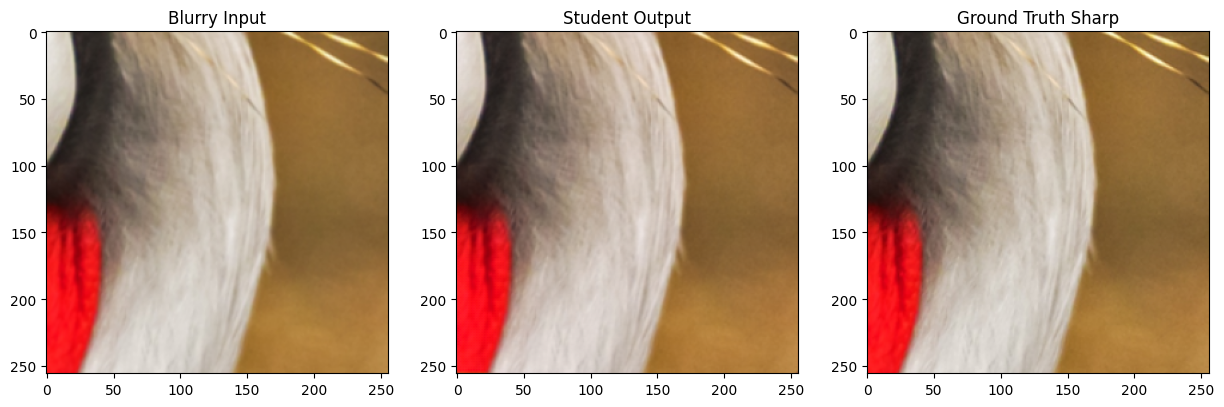

In [10]:
import matplotlib.pyplot as plt

# put the student in evaluation mode
student.eval()

# pick a random image
test_img_name = train_dataset.image_names[10]  # you can change index

blur_path  = os.path.join(train_dataset.blur_dir, test_img_name)
sharp_path = os.path.join(train_dataset.sharp_dir, test_img_name)

# load and resize
blur = cv2.imread(blur_path)
blur = cv2.cvtColor(blur, cv2.COLOR_BGR2RGB)
blur = cv2.resize(blur, (256,256)) / 255.0

sharp = cv2.imread(sharp_path)
sharp = cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB)
sharp = cv2.resize(sharp, (256,256)) / 255.0

# to tensor
blur_tensor = torch.from_numpy(blur).permute(2,0,1).unsqueeze(0).float().to(device)

# student output
with torch.no_grad():
    student_output = student(blur_tensor)

student_img = student_output.squeeze(0).permute(1,2,0).cpu().numpy()
student_img = np.clip(student_img, 0, 1)

# plot
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(blur)
plt.title("Blurry Input")
plt.subplot(1,3,2)
plt.imshow(student_img)
plt.title("Student Output")
plt.subplot(1,3,3)
plt.imshow(sharp)
plt.title("Ground Truth Sharp")
plt.show()


In [12]:
from skimage.metrics import structural_similarity as ssim_metric
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
import numpy as np
import cv2
import os

# Put student in eval mode
student.eval()

ssim_scores = []
psnr_scores = []

for i in range(len(train_dataset)):
    # Load image paths
    blur_path = os.path.join(train_dataset.blur_dir, train_dataset.image_names[i])
    sharp_path = os.path.join(train_dataset.sharp_dir, train_dataset.image_names[i])
    
    # Load and preprocess
    blur = cv2.imread(blur_path)
    blur = cv2.cvtColor(blur, cv2.COLOR_BGR2RGB)
    blur = cv2.resize(blur, (256,256)) / 255.0
    
    sharp = cv2.imread(sharp_path)
    sharp = cv2.cvtColor(sharp, cv2.COLOR_BGR2RGB)
    sharp = cv2.resize(sharp, (256,256)) / 255.0
    
    blur_tensor = torch.from_numpy(blur).permute(2,0,1).unsqueeze(0).float().to(device)

    # Get student output
    with torch.no_grad():
        student_out = student(blur_tensor)

    student_img = student_out.squeeze(0).permute(1,2,0).cpu().numpy()
    student_img = np.clip(student_img, 0, 1)

    # Compute SSIM with channel_axis
    ssim_score = ssim_metric(
        (sharp * 255).astype(np.uint8),
        (student_img * 255).astype(np.uint8),
        channel_axis=2
    )
    
    psnr_score = psnr_metric(
        (sharp * 255).astype(np.uint8),
        (student_img * 255).astype(np.uint8)
    )

    ssim_scores.append(ssim_score)
    psnr_scores.append(psnr_score)

# Final metrics
avg_ssim = np.mean(ssim_scores)
avg_psnr = np.mean(psnr_scores)

print(f"✅ Average SSIM: {avg_ssim*100:.2f}%")
print(f"✅ Average PSNR: {avg_psnr:.2f} dB")


✅ Average SSIM: 98.72%
✅ Average PSNR: 37.91 dB


In [13]:
import torch

# Save trained student model to a file
torch.save(student.state_dict(), "residual_unet_student.pth")

print("✅ Student model saved as 'residual_unet_student.pth'")


✅ Student model saved as 'residual_unet_student.pth'
